In [1]:
import sys
import itertools
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from tsfresh.feature_extraction import extract_features
from multiprocessing import Pool
tqdm.pandas(desc="apply progress")

import warnings
warnings.filterwarnings('ignore')

## データ整形の関数群

In [2]:
aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean'],
    'flux_ratio_sq': ['sum', 'skew'],
    'flux_by_flux_ratio_sq': ['sum', 'skew'],
}

# agg diff features
diff_aggs = {
    'flux_diff': ['min', 'max', 'mean', 'median', 'std', 'skew'],
}

# tsfresh features
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
        'mean': None,
        'maximum': None,
        'minimum': None,
        # additional
        'absolute_sum_of_changes': None,
        'autocorrelation': [{'lag': 3}],
        'binned_entropy': [{'max_bins': 10}],
        'cid_ce': [{'normalize': True}],
        'count_above_mean': None,
        'first_location_of_maximum': None,
        'first_location_of_minimum': None,
        'last_location_of_maximum': None,
        'last_location_of_minimum': None,
        'mean_second_derivative_central': None,
        'median': None,
        'ratio_beyond_r_sigma': [{'r': 2}],
        'sample_entropy': None,
        'time_reversal_asymmetry_statistic': [{'lag': 4}]
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        # additional
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
        'mean': None,
        'maximum': None,
        'minimum': None,
        'abs_energy': None,
        'absolute_sum_of_changes': None,
        'autocorrelation': [{'lag': 3}],
        'binned_entropy': [{'max_bins': 10}],
        'cid_ce': [{'normalize': True}],
        'count_above_mean': None,
        'count_below_mean': None,
        'first_location_of_maximum': None,
        'first_location_of_minimum': None,
        'kurtosis': None,
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_second_derivative_central': None,
        'median': None,
        'sample_entropy': None,
        'standard_deviation': None,
        'time_reversal_asymmetry_statistic': [{'lag': 3}]
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'},
                {'coeff': 1, 'attr': 'abs'}
            ],
        'kurtosis': None,
        'skewness': None,
        'maximum': None,
        'mean': None,
        'minimum': None,
        # additional
        'abs_energy': None,
        'autocorrelation': [{'lag': 3}],
        'binned_entropy': [{'max_bins': 10}],
        'cid_ce': [{'normalize': True}],
        'mean_second_derivative_central': None,
        'median': None,
        'sample_entropy': None,
        'standard_deviation': None,
        'sum_values': None,
        'time_reversal_asymmetry_statistic': [{'lag': 4}]
    },

    'fcp2':  {
        "fft_coefficient": [{
            "coeff": 0,
            "attr": "abs"
        }, {
            "coeff": 1,
            "attr": "abs"
        }],
        "abs_energy": None,
        "sample_entropy": None
    },

    'mjd': {
        'maximum': None,
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [3]:
def haversine_plus(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees) from
    #https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    # Implementing Haversine Formula:
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(
        np.power(np.sin(np.divide(dlat, 2)), 2),
        np.multiply(
            np.cos(lat1),
            np.multiply(np.cos(lat2), np.power(np.sin(np.divide(dlon, 2)),
                                               2))))

    haversine = np.multiply(2, np.arcsin(np.sqrt(a)))
    return {
        'haversine': haversine,
        'latlon1': np.subtract(
            np.multiply(lon1, lat1), np.multiply(lon2, lat2)),
    }


def process_flux(df):
    flux_ratio_sq = np.power(df['flux'].values / df['flux_err'].values, 2.0)

    df_flux = pd.DataFrame(
        {
            'flux_ratio_sq': flux_ratio_sq,
            'flux_by_flux_ratio_sq': df['flux'].values * flux_ratio_sq,
        },
        index=df.index)

    return pd.concat([df, df_flux], axis=1)


def process_flux_agg(df):
    flux_w_mean = df['flux_by_flux_ratio_sq_sum'].values / df[
        'flux_ratio_sq_sum'].values
    flux_diff = df['flux_max'].values - df['flux_min'].values

    df_flux_agg = pd.DataFrame(
        {
            'flux_w_mean': flux_w_mean,
            'flux_diff1': flux_diff,
            'flux_diff2': flux_diff / df['flux_mean'].values,
            'flux_diff3': flux_diff / flux_w_mean,
        },
        index=df.index)

    return pd.concat([df, df_flux_agg], axis=1)


def make_diff_feature(df):
    tmp = df.groupby(['object_id', 'passband',
                      'mjd'])['flux'].sum().reset_index()

    tmp['flux_diff'] = tmp['flux'] - tmp['flux'].shift(1)
    multi_id_list = (tmp['object_id'].astype(str) + '-' +
                     tmp['passband'].astype(str)).values

    drop_index = []
    prev_val = 'hoge'
    for index, val in enumerate(multi_id_list):
        if val != prev_val:
            drop_index.append(index)
        prev_val = val

    use_index = list(set(tmp.index) - set(drop_index))
    tmp = tmp.iloc[use_index, :]
    diff_df = tmp.drop('flux', axis=1)

    return diff_df


def featurize(df, df_meta, aggs, fcp, n_jobs=72):
    """
    Extracting Features from train set
    Features from olivier's kernel
    very smart and powerful feature that is generously given here https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696#410538
    per passband features with tsfresh library. fft features added to capture periodicity https://www.kaggle.com/c/PLAsTiCC-2018/discussion/70346#415506
    """

    df = process_flux(df)

    agg_df = df.groupby('object_id').agg(aggs)
    agg_df.columns = [
        '{}_{}'.format(k, agg) for k in aggs.keys() for agg in aggs[k]
    ]
    agg_df = process_flux_agg(agg_df)  # new feature to play with tsfresh
    per_passband_aggs = {
        "flux": ["min", "max", "mean", "std"],
        "flux_ratio_sq": ["sum", "skew"],
        "flux_by_flux_ratio_sq": ["sum", "skew"]
    }
    per_pass_agg_df = df.groupby(["object_id",
                                  "passband"]).agg(per_passband_aggs)
    per_pass_agg_df.columns = pd.Index(
        [e[0] + "_" + e[1] for e in per_pass_agg_df.columns])
    per_pass_agg_df["flux_diff"] = per_pass_agg_df[
        "flux_max"] - per_pass_agg_df["flux_min"]
    per_pass_agg_df["flux_diff2"] = (
        per_pass_agg_df["flux_max"] -
        per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_mean"]
    per_pass_agg_df["flux_w_mean"] = per_pass_agg_df[
        "flux_by_flux_ratio_sq_sum"] / per_pass_agg_df["flux_ratio_sq_sum"]
    per_pass_agg_df["flux_dif3"] = (
        per_pass_agg_df["flux_max"] -
        per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_w_mean"]
    per_pass_agg_df = per_pass_agg_df.unstack()
    per_pass_agg_df.columns = pd.Index(
        [str(e[1]) + "__" + e[0] for e in per_pass_agg_df.columns])

    basic_columns = [
        f"{i}__{j}" for i in range(6) for j in [
            "flux_min", "flux_max", "flux_mean", "flux_std",
            "flux_ratio_sq_sum", "flux_ratio_sq_skew", "flux_w_mean",
            "flux_diff2"
        ]
    ]
    per_pass_agg_df.drop(basic_columns, axis=1, inplace=True)

    agg_df = pd.merge(agg_df, per_pass_agg_df, how="left", on="object_id")

    agg_flux_diff = agg_df.reset_index()[["object_id", "flux_diff1"]]
    df2 = pd.merge(df, agg_flux_diff, how="left", on="object_id")
    df2["flux_norm"] = df2.flux / df2.flux_diff1
    del df2["flux"]

    # Add more features with
    agg_df_ts_flux_passband = extract_features(
        df,
        column_id='object_id',
        column_sort='mjd',
        column_kind='passband',
        column_value='flux',
        default_fc_parameters=fcp['flux_passband'],
        n_jobs=n_jobs)

    agg_df_ts_flux = extract_features(
        df,
        column_id='object_id',
        column_value='flux',
        default_fc_parameters=fcp['flux'],
        n_jobs=n_jobs)

    agg_df_ts2 = extract_features(
        df2,
        column_id="object_id",
        column_sort="mjd",
        column_kind="passband",
        column_value="flux_norm",
        default_fc_parameters=fcp["fcp2"],
        n_jobs=n_jobs)

    agg_df_ts_flux_by_flux_ratio_sq = extract_features(
        df,
        column_id='object_id',
        column_value='flux_by_flux_ratio_sq',
        default_fc_parameters=fcp['flux_by_flux_ratio_sq'],
        n_jobs=n_jobs)

    # Add smart feature that is suggested here https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696#410538
    # dt[detected==1, mjd_diff:=max(mjd)-min(mjd), by=object_id]
    df_det = df[df['detected'] == 1].copy()
    agg_df_mjd = extract_features(
        df_det,
        column_id='object_id',
        column_value='mjd',
        default_fc_parameters=fcp['mjd'],
        n_jobs=n_jobs)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd[
        'mjd__maximum'].values - agg_df_mjd['mjd__minimum'].values
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts2.columns = pd.Index([e + "_norm" for e in agg_df_ts2.columns])
    agg_df_ts_flux_passband.index.rename('object_id', inplace=True)
    agg_df.index.rename('object_id', inplace=True)
    agg_df_ts_flux.index.rename('object_id', inplace=True)
    agg_df_ts_flux_by_flux_ratio_sq.index.rename('object_id', inplace=True)
    agg_df_mjd.index.rename('object_id', inplace=True)
    agg_df_ts = pd.concat([
        agg_df, agg_df_ts2, agg_df_ts_flux_passband, agg_df_ts_flux,
        agg_df_ts_flux_by_flux_ratio_sq, agg_df_mjd
    ],
                          axis=1).reset_index()

    result = agg_df_ts.merge(right=df_meta, how='left', on='object_id')
    return result


def diff_featurize(diff_df, df_meta, diff_aggs, fcp, n_jobs=72):
    """
    Extracting Features from train set
    Features from olivier's kernel
    very smart and powerful feature that is generously given here https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696#410538
    per passband features with tsfresh library. fft features added to capture periodicity https://www.kaggle.com/c/PLAsTiCC-2018/discussion/70346#415506
    """

    # df = train.copy()

    # diff_df = process_flux(diff_df)

    diff_agg_df = diff_df.groupby('object_id').agg(diff_aggs)
    diff_agg_df.columns = [
        '{}_{}'.format(k, agg) for k in diff_aggs.keys()
        for agg in diff_aggs[k]
    ]
    # diff_agg_df = process_flux_agg(diff_agg_df) # new feature to play with tsfresh

    # Add more features with
    diff_agg_df_ts_flux_passband = extract_features(
        diff_df,
        column_id='object_id',
        column_sort='mjd',
        column_kind='passband',
        column_value='flux_diff',
        default_fc_parameters=fcp['flux_passband'],
        n_jobs=n_jobs)

    diff_agg_df_ts_flux = extract_features(
        diff_df,
        column_id='object_id',
        column_value='flux_diff',
        default_fc_parameters=fcp['flux'],
        n_jobs=n_jobs)

    diff_agg_df_ts_flux_passband.index.rename('object_id', inplace=True)
    diff_agg_df_ts_flux_passband.columns = [
        column + '_diff' for column in diff_agg_df_ts_flux_passband.columns
    ]
    diff_agg_df_ts_flux.index.rename('object_id', inplace=True)
    # agg_df_ts_flux_by_flux_ratio_sq.index.rename('object_id', inplace=True)
    # agg_df_mjd.index.rename('object_id', inplace=True)
    diff_agg_df_ts = pd.concat(
        [
            diff_agg_df,
            diff_agg_df_ts_flux_passband,
            diff_agg_df_ts_flux,
            # agg_df_ts_flux_by_flux_ratio_sq,
            # agg_df_mjd
        ],
        axis=1).reset_index()

    # result = agg_df_ts.merge(right=df_meta, how='left', on='object_id')
    result = diff_agg_df_ts
    return result


def process_meta(meta_df):
    meta_dict = dict()

    # id trick
    for i in [22, 27]:
        meta_dict['object_id_div_{}'.format(i)] = np.mod(
            meta_df['object_id'].values, i)

    # distance
    meta_dict.update(
        haversine_plus(meta_df['ra'].values, meta_df['decl'].values,
                       meta_df['gal_l'].values, meta_df['gal_b'].values))
    #
    meta_dict['hostgal_photoz_certain'] = np.multiply(
        meta_df['hostgal_photoz'].values,
        np.exp(meta_df['hostgal_photoz_err'].values))

    meta_df = pd.concat(
        [meta_df, pd.DataFrame(meta_dict, index=meta_df.index)], axis=1)
    return meta_df


def add_rank_bottom_and_top(df, feature_name):
    objid = ["object_id"]
    columns = [f"{i}{feature_name}" for i in range(6)]
    partial_df = df[objid + columns]
    partial_values = partial_df.melt(
        id_vars=objid, value_vars=columns).sort_values(["object_id", "value"])

    top_and_bottom = partial_values.groupby("object_id").agg({
        "variable": ["first", "last"]
    })
    top_and_bottom.columns = ["top" + feature_name, "bottom" + feature_name]
    for i, n in zip(["0", "1", "2", "3", "4", "5"], columns):
        top_and_bottom = top_and_bottom.replace(n, i)
    top_and_bottom = top_and_bottom.astype(int)
    return top_and_bottom


def add_by_features(df, feature_name, new_feat_name):
    for i in range(5):
        for j in range(1, 6):
            if j > i:
                df[f"{new_feat_name}{j}_by_{i}"] = df[
                    f"{j}{feature_name}"] / df[f"{i}{feature_name}"]
    return df

In [4]:
# single_superの特徴量整形用関数
def train_data_super(train, meta_train):
    y = meta_train.target
    meta_train = process_meta(meta_train)
    
    # 特徴量作成
    full_train = featurize(train, meta_train, aggs, fcp, n_jobs=72)
    # print('full train shape :', full_train.shape)

    # 差分特徴量（ver0で作成）
    diff_train = make_diff_feature(train)
    diff_full_train = diff_featurize(diff_train, meta_train, diff_aggs, fcp, n_jobs=72)

    # 特徴量のマージ
    full_train = pd.merge(full_train, diff_full_train, on='object_id')

    # ランクの特徴量を追加
    full_train = add_by_features(
        full_train, "__fft_coefficient__coeff_0__attr_\"abs\"_norm",
        "flux_norm_fft_")
    full_train = add_by_features(full_train, "__abs_energy_norm", "abs_energy_")
    full_train = add_by_features(full_train, "__flux_diff", "flux_diff_")
    abs_energy = add_rank_bottom_and_top(full_train, "__abs_energy_norm")
    flux_diff = add_rank_bottom_and_top(full_train, "__flux_diff")
    flux_dif3 = add_rank_bottom_and_top(full_train, "__flux_dif3")

    full_train = pd.merge(full_train, abs_energy, how="left", on="object_id")
    full_train = pd.merge(full_train, flux_diff, how="left", on="object_id")
    full_train = pd.merge(full_train, flux_dif3, how="left", on="object_id")
    
    if 'target' in full_train:
        # y = full_train['target']
        del full_train['target']

    classes = sorted(y.unique())
    
    class_weights = {c: 1 for c in classes}
    class_weights.update({c: 2 for c in [64, 15]})
    
    oof_df = full_train[["object_id"]]
    
    # モデル前整形
    if 'object_id' in full_train:
        del full_train['object_id']
        # del full_train['distmod']
        del full_train['hostgal_specz']
        del full_train['ra'], full_train['decl'], full_train['gal_l'], full_train['gal_b']
        del full_train['ddf']
    
    full_train = full_train.replace(np.inf, np.nan)
    full_train = full_train.replace(-np.inf, np.nan)

    scl = StandardScaler()
    full_train = pd.DataFrame(scl.fit_transform(full_train), index=full_train.index, columns=full_train.columns)
    full_train.fillna(0, inplace=True)
    
    use_features = pd.read_csv('./use_features_5-0.csv')['use_feature'].tolist()
    full_train = full_train[use_features]
    
    return full_train, y, classes, class_weights, oof_df, scl

## 予測関連の関数群

In [5]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {
        6: 1,
        15: 2,
        16: 1,
        42: 1,
        52: 1,
        53: 1,
        62: 1,
        64: 2,
        65: 1,
        67: 1,
        88: 1,
        90: 1,
        92: 1,
        95: 1
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {
        6: 1,
        15: 2,
        16: 1,
        42: 1,
        52: 1,
        53: 1,
        62: 1,
        64: 2,
        65: 1,
        67: 1,
        88: 1,
        90: 1,
        92: 1,
        95: 1
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

def multi_weighted_logloss_novae(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [15, 42, 52, 62, 67, 90]
    class_weight = {
        15: 2,
        42: 1,
        52: 1,
        62: 1,
        67: 1,
        90: 1,
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss_novae(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [15, 42, 52, 62, 67, 90]
    class_weight = {
        15: 2,
        42: 1,
        52: 1,
        62: 1,
        67: 1,
        90: 1,
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


def multi_weighted_logloss_nonnovae(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 16, 53, 64, 65, 88, 92, 95]
    class_weight = {6: 1, 16: 1, 53: 1, 64: 2, 65: 1, 88: 1, 92: 1, 95: 1}
    
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss_nonnovae(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 16, 53, 64, 65, 88, 92, 95]
    class_weight = {6: 1, 16: 1, 53: 1, 64: 2, 65: 1, 88: 1, 92: 1, 95: 1}
    
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [6]:
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 12))
    sns.barplot(
        x='gain',
        y='feature',
        data=importances_.sort_values('mean_gain', ascending=False)[:300])
    plt.tight_layout()
    plt.savefig('importances_novae.png')


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def save_cm(y, oof_preds):
    unique_y = np.unique(y)
    class_map = dict()
    for i, val in enumerate(unique_y):
        class_map[val] = i

    y_map = np.zeros((y.shape[0], ))
    y_map = np.array([class_map[val] for val in y])

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds, axis=-1))
    np.set_printoptions(precision=2)

    class_names = ["class_15", "class_42", "class_52", "class_62", "class_67", "class_90"]
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12, 12))
    plot_confusion_matrix(
        cnf_matrix,
        classes=class_names,
        normalize=True,
        title='Confusion matrix')
    plt.savefig("confusion_matrix_novae.png")
    
def plot_importances(clfs, features):
    importances = []
    for clf in clfs:
        importances.append(clf.feature_importances_)
    importances = pd.Series(np.array(importances).mean(axis=0), index=features)
    importances = importances.sort_values(ascending=False)

    fig, ax = plt.subplots(1,1,figsize=(14,14))
    importances.iloc[:40].plot(kind='barh', ax=ax)
    fig.tight_layout()

    return importances

In [7]:
def smoteAdataset(Xig_train, yig_train, Xig_test, yig_test):     
    sm=SMOTE(random_state=2)
    Xig_train_res, yig_train_res = sm.fit_sample(Xig_train, yig_train.ravel())
    return Xig_train_res, pd.Series(yig_train_res), Xig_test, pd.Series(yig_test)

In [8]:
def lgbm_modeling_cross_validation(params,
                                   full_train, 
                                   y, 
                                   classes, 
                                   class_weights,
                                   lgb_metric,
                                   metric,
                                   nr_fold=12, 
                                   random_state=1, 
                                   save_plot=True, 
                                   show_log=True,):

    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
   # print(weights)
   # weights=class_weights
    clfs = []
    importances = pd.DataFrame()
    folds = StratifiedKFold(n_splits=nr_fold, 
                            shuffle=True, 
                            random_state=random_state)
    
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]
        
                
        trn_xa, trn_y, val_xa, val_y=smoteAdataset(trn_x.values, trn_y.values, val_x.values, val_y.values)
        trn_x=pd.DataFrame(data=trn_xa, columns=trn_x.columns)
    
        val_x=pd.DataFrame(data=val_xa, columns=val_x.columns)
        
        categorical_feature = []
        categorical_feature = list(set(categorical_feature) & set(full_train.columns))
        
        clf = lgb.LGBMClassifier(**params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_metric,
            verbose=100,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights),
            categorical_feature=categorical_feature
        )
        clfs.append(clf)

        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        
        if show_log:
            print('no {}-fold loss: {}'.format(fold_ + 1, 
                  metric(val_y, oof_preds[val_, :])))
    
        imp_df = pd.DataFrame({
                'feature': full_train.columns,
                'gain': clf.feature_importances_,
                'fold': [fold_ + 1] * len(full_train.columns),
                })
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

    score = metric(y_true=y, y_preds=oof_preds)
    print('MULTI WEIGHTED LOG LOSS: {:.5f}'.format(score))
    
    if save_plot:
        df_importances = save_importances(importances_=importances)
    
    return clfs, score, oof_preds

## データ読み込んだり諸々

In [9]:
# data_dir = "/home/hidehisa/.kaggle/competitions/plasticc"
data_dir = "../input"
# train = pd.read_csv(data_dir + "/train_with_cluster.csv")
train = pd.read_csv(data_dir + "/training_set.csv")
meta = pd.read_csv(data_dir + "/training_set_metadata.csv")

In [10]:
nova = [15, 42, 52, 62, 67, 90]
nonnova = [6, 16, 53, 64, 65, 88, 92, 95]
novaes = meta.query("target == @nova")
nonnovaes = meta.query("target == @nonnova")
object_ids_novae = novaes['object_id'].tolist()
object_ids_nonnovae = nonnovaes['object_id'].tolist()

In [11]:
full, y, classes, class_weight, oof_df, scl = train_data_super(train, meta)

Feature Extraction: 100%|██████████| 357/357 [00:10<00:00, 35.33it/s]


In [12]:
index_novae = oof_df[oof_df['object_id'].isin(object_ids_novae)].index
index_nonnovae = oof_df[oof_df['object_id'].isin(object_ids_nonnovae)].index

In [13]:
# 二値分類用のカラムを追加
train_bin = train.copy()
train_bin["novae"] = 0
ind = train_bin.query("object_id in @novaes.object_id").index
train_bin.loc[ind, "novae"] = 1

In [94]:
len(full_novae)
len(full_nonnova)

2972

## Nova

In [14]:
full_novae = full.ix[index_novae, :]
y_novae = y.ix[index_novae]
classes_novae = nova
class_weight_novae = {c:class_weight[c] for c in classes_novae}
oof_df_novae = oof_df.ix[index_novae]

In [15]:
classes_novae

[15, 42, 52, 62, 67, 90]

In [16]:
class_weight_novae

{15: 2, 42: 1, 52: 1, 62: 1, 67: 1, 90: 1}

In [17]:
full_novae.shape

(4876, 159)

In [18]:
train_mean_novae = full_novae.mean(axis=0)
full_novae.head()

,hostgal_photoz,mjd_diff_det,distmod,hostgal_photoz_certain,hostgal_photoz_err,mjd__mean_abs_change,flux__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_above_mean,flux__sample_entropy,flux_by_flux_ratio_sq__median,...,5__minimum,2__median_diff,2__sample_entropy_norm,"3__fft_coefficient__coeff_0__attr_""abs""_diff",0__flux_dif3,flux__count_above_mean,"5__fft_coefficient__coeff_0__attr_""abs""_diff",1__binned_entropy__max_bins_10_diff,abs_energy_4_by_1,flux_norm_fft_4_by_1
2,-0.241394,-0.589269,-0.445462,-0.262324,-0.466108,-0.374960,-0.080038,-0.338573,-0.071971,0.012904,...,0.100926,-0.005878,-0.135735,-0.164526,0.323564,0.692188,-0.103767,1.425783,-0.012985,-0.016728
3,-0.140389,-0.460203,-0.207231,0.234628,3.318166,-0.389014,0.324778,-0.338573,-1.140755,0.012904,...,0.105010,-0.010614,-0.859170,-0.165232,-0.011345,0.287513,-0.108075,-2.468070,-0.013107,-0.021403
4,-0.213347,-0.430823,-0.374523,-0.250282,-0.459782,-0.387437,0.324778,-0.029492,-0.806847,0.012904,...,0.104730,-0.009448,-0.658954,-0.161596,-0.001720,0.406535,-0.103763,-0.678029,-0.013083,-0.021430
6,-0.322418,-0.771992,-0.678920,-0.294038,-0.417165,-0.400689,0.189839,0.073535,-2.091914,0.012904,...,0.103358,-0.006116,-1.624354,0.735732,-0.011956,-0.974123,0.213715,-2.669705,-0.013112,-0.021700
7,0.629707,-0.807244,0.834667,0.097730,-0.485086,-0.394572,-0.349915,-0.390086,0.647812,0.012904,...,0.103050,-0.002858,1.299714,-0.156633,-0.001878,1.501539,-0.090677,1.353791,-0.013080,-0.018071


In [19]:
oof_df_novae.head()

,object_id
2,730
3,745
4,1124
6,1598
7,1632


In [20]:
with open("novae_bestmodel.pickle", "rb") as f:
    novae_params = pickle.load(f)
novae_params

{'learning_rate': 0.11867360319143158,
 'min_child_weight': 38,
 'max_depth': 7,
 'colsample_bytree': 0.2724454629400727,
 'subsample': 0.23967297293038575,
 'reg_lambda': 877.3455173681164,
 'subsample_freq': 5,
 'subsample_for_bin': 4958,
 'min_data_per_group': 603,
 'max_cat_to_onehot': 6,
 'cat_l2': 2.0,
 'cat_smooth': 33.97192840095782,
 'max_cat_threshold': 11,
 'metric_freq': 6,
 'drop_rate': 1.0,
 'max_drop': 3,
 'min_child_samples': 29,
 'min_split_gain': 0.37927454309625563,
 'num_leaves': 11,
 'reg_alpha': 0.11473001246736834,
 'skip_drop': 0.10297461618769321,
 'device': 'cpu',
 'objective': 'multiclass',
 'boosting_type': 'gbdt',
 'n_jobs': -1,
 'xgboost_dart_mode': False,
 'uniform_drop': False,
 'metric': 'multi_logloss',
 'n_estimators': 500}

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.444228	training's wloss: 0.835342	valid_1's multi_logloss: 1.79855	valid_1's wloss: 1.18186
[200]	training's multi_logloss: 0.281654	training's wloss: 0.572984	valid_1's multi_logloss: 1.42852	valid_1's wloss: 1.06732
[300]	training's multi_logloss: 0.20589	training's wloss: 0.437457	valid_1's multi_logloss: 1.23432	valid_1's wloss: 1.03081
Early stopping, best iteration is:
[339]	training's multi_logloss: 0.186268	training's wloss: 0.403025	valid_1's multi_logloss: 1.19157	valid_1's wloss: 1.02598
no 1-fold loss: 1.0259766934697654
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.448148	training's wloss: 0.833019	valid_1's multi_logloss: 1.80818	valid_1's wloss: 1.18174
[200]	training's multi_logloss: 0.285305	training's wloss: 0.570948	valid_1's multi_logloss: 1.42579	valid_1's wloss: 1.06642
[300]	training's multi_logloss: 0.209003	training's

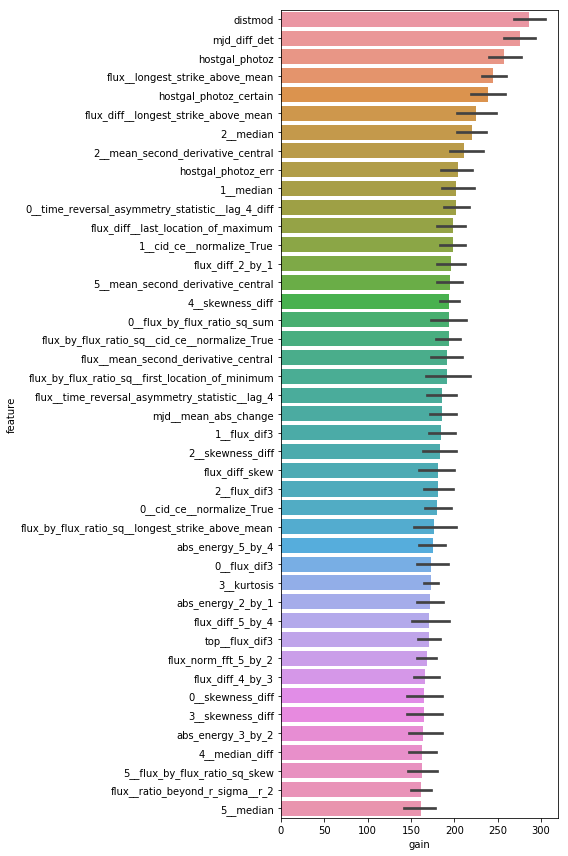

In [21]:
# チューニングに使ったパラーメータは荒居モデルの特徴量でチューニングしたが、今入れてる特徴量はsingle_superの特徴量
# single_superの特徴量で再度チューニングしたら精度上がるかも？
nova_clfs, nova_score, nova_oof = lgbm_modeling_cross_validation(
    novae_params,
    # full_novae[nova_feature_list],
    full_novae,
    y_novae,
    classes_novae,
    class_weight_novae,
    lgb_multi_weighted_logloss_novae,
    multi_weighted_logloss_novae,
    7,
    7
)

In [22]:
# 1.0039164101614582
nova_score

1.0039164101614582

## Non-nova

In [23]:
full_nonnova = full.ix[index_nonnovae, :]
y_nonnova = y.ix[index_nonnovae]
classes_nonnova = nonnova
class_weight_nonnova = {c:class_weight[c] for c in classes_nonnova}
oof_df_nonnova = oof_df.ix[index_nonnovae]

In [24]:
classes_nonnova

[6, 16, 53, 64, 65, 88, 92, 95]

In [25]:
class_weight_nonnova

{6: 1, 16: 1, 53: 1, 64: 2, 65: 1, 88: 1, 92: 1, 95: 1}

In [26]:
full_nonnova.shape

(2972, 159)

In [27]:
train_mean_nonnova = full_nonnova.mean(axis=0)
full_nonnova.head()

,hostgal_photoz,mjd_diff_det,distmod,hostgal_photoz_certain,hostgal_photoz_err,mjd__mean_abs_change,flux__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_above_mean,flux__sample_entropy,flux_by_flux_ratio_sq__median,...,5__minimum,2__median_diff,2__sample_entropy_norm,"3__fft_coefficient__coeff_0__attr_""abs""_diff",0__flux_dif3,flux__count_above_mean,"5__fft_coefficient__coeff_0__attr_""abs""_diff",1__binned_entropy__max_bins_10_diff,abs_energy_4_by_1,flux_norm_fft_4_by_1
0,-0.656047,1.695338,0.000000,-0.435164,-0.518381,-0.383737,0.324778,1.258347,1.655294,0.003365,...,-0.084047,0.150041,0.981416,0.526314,-0.033816,3.286872,0.140026,1.645802,-0.013112,-0.021766
1,2.325896,1.617782,1.830863,1.144162,0.331300,-0.275310,2.416326,9.706566,1.714691,0.012904,...,0.103194,-0.013254,1.209489,-0.150699,-0.020628,2.882197,-0.098962,0.813238,-0.013109,-0.021642
5,-0.656047,1.172829,0.000000,-0.435164,-0.518381,2.792542,-0.552323,-0.493113,0.360955,0.012904,...,0.103889,-0.005511,1.170261,-0.164867,-0.012382,2.144259,-0.106235,0.385199,-0.013098,-0.021359
9,-0.656047,0.436703,0.000000,-0.435164,-0.518381,1.607677,-0.552323,-0.493113,0.448152,0.012904,...,0.085527,-0.008414,-0.673432,-0.164174,-0.007678,1.834801,-0.099796,1.431659,-0.013090,-0.020400
14,-0.656047,0.594662,0.000000,-0.435164,-0.518381,0.159419,-0.687262,-0.441600,-2.084983,0.012904,...,0.098506,-0.004796,-0.708554,-0.162934,-0.012154,-0.640861,-0.097235,-1.151889,-0.007975,-0.015242


In [28]:
with open("non_novae_bestmodel.pickle", "rb") as f:
    nonnova_params = pickle.load(f)
nonnova_params

{'learning_rate': 0.04192412408246463,
 'min_child_weight': 13,
 'max_depth': 4,
 'colsample_bytree': 0.4759418223343803,
 'subsample': 1.0,
 'reg_lambda': 127.36420680116525,
 'subsample_freq': 3,
 'subsample_for_bin': 4565,
 'min_data_per_group': 52,
 'max_cat_to_onehot': 8,
 'cat_l2': 0.3305970688093518,
 'cat_smooth': 77.10964159662572,
 'max_cat_threshold': 56,
 'metric_freq': 5,
 'drop_rate': 0.29371216623092405,
 'max_drop': 2,
 'min_child_samples': 30,
 'min_split_gain': 0.9715127224883426,
 'num_leaves': 9,
 'reg_alpha': 0.407581952815788,
 'skip_drop': 0.4999752454841748,
 'device': 'cpu',
 'objective': 'multiclass',
 'boosting_type': 'gbdt',
 'n_jobs': -1,
 'xgboost_dart_mode': False,
 'uniform_drop': False,
 'metric': 'multi_logloss',
 'n_estimators': 500}

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.0292766	training's wloss: 0.0663686	valid_1's multi_logloss: 0.19336	valid_1's wloss: 0.125459
[200]	training's multi_logloss: 0.00417727	training's wloss: 0.0123218	valid_1's multi_logloss: 0.0705254	valid_1's wloss: 0.0631375
[300]	training's multi_logloss: 0.00203697	training's wloss: 0.00644125	valid_1's multi_logloss: 0.0528295	valid_1's wloss: 0.0611273
Early stopping, best iteration is:
[306]	training's multi_logloss: 0.0019842	training's wloss: 0.0062879	valid_1's multi_logloss: 0.052346	valid_1's wloss: 0.0607643
no 1-fold loss: 0.060764348608283426
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.0291953	training's wloss: 0.0650285	valid_1's multi_logloss: 0.180364	valid_1's wloss: 0.144043
[200]	training's multi_logloss: 0.00412498	training's wloss: 0.0123181	valid_1's multi_logloss: 0.0738198	valid_1's wloss: 0.0784824
[300]	training

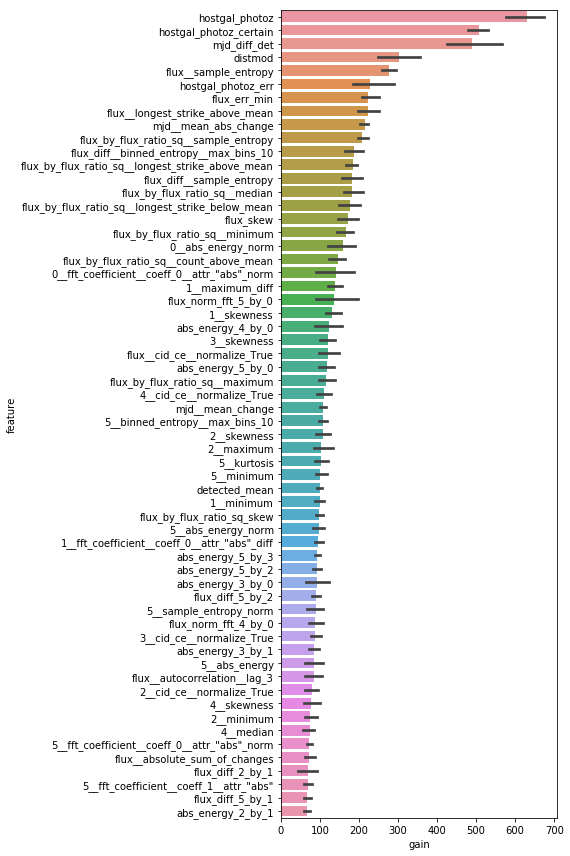

In [29]:
# チューニングに使ったパラーメータは荒居モデルの特徴量でチューニングしたが、今入れてる特徴量はsingle_superの特徴量
# single_superの特徴量で再度チューニングしたら精度上がるかも？
nonnova_clfs, nonnova_score, nonnova_oof = lgbm_modeling_cross_validation(
    nonnova_params,
    full_nonnova,
    y_nonnova,
    classes_nonnova,
    class_weight_nonnova,
    lgb_multi_weighted_logloss_nonnovae,
    multi_weighted_logloss_nonnovae,
    5,
    7
)

In [30]:
# 0.05067903883306674
nonnova_score

0.05067903883306674

## Binary

In [31]:
y_bin = train_bin.groupby("object_id").novae.mean()
y_bin.head()

object_id
615     0
713     0
730     1
745     1
1124    1
Name: novae, dtype: int64

In [32]:
train_mean = full.mean(axis=0)
full.head()

,hostgal_photoz,mjd_diff_det,distmod,hostgal_photoz_certain,hostgal_photoz_err,mjd__mean_abs_change,flux__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_above_mean,flux__sample_entropy,flux_by_flux_ratio_sq__median,...,5__minimum,2__median_diff,2__sample_entropy_norm,"3__fft_coefficient__coeff_0__attr_""abs""_diff",0__flux_dif3,flux__count_above_mean,"5__fft_coefficient__coeff_0__attr_""abs""_diff",1__binned_entropy__max_bins_10_diff,abs_energy_4_by_1,flux_norm_fft_4_by_1
0,-0.656047,1.695338,0.000000,-0.435164,-0.518381,-0.383737,0.324778,1.258347,1.655294,0.003365,...,-0.084047,0.150041,0.981416,0.526314,-0.033816,3.286872,0.140026,1.645802,-0.013112,-0.021766
1,2.325896,1.617782,1.830863,1.144162,0.331300,-0.275310,2.416326,9.706566,1.714691,0.012904,...,0.103194,-0.013254,1.209489,-0.150699,-0.020628,2.882197,-0.098962,0.813238,-0.013109,-0.021642
2,-0.241394,-0.589269,-0.445462,-0.262324,-0.466108,-0.374960,-0.080038,-0.338573,-0.071971,0.012904,...,0.100926,-0.005878,-0.135735,-0.164526,0.323564,0.692188,-0.103767,1.425783,-0.012985,-0.016728
3,-0.140389,-0.460203,-0.207231,0.234628,3.318166,-0.389014,0.324778,-0.338573,-1.140755,0.012904,...,0.105010,-0.010614,-0.859170,-0.165232,-0.011345,0.287513,-0.108075,-2.468070,-0.013107,-0.021403
4,-0.213347,-0.430823,-0.374523,-0.250282,-0.459782,-0.387437,0.324778,-0.029492,-0.806847,0.012904,...,0.104730,-0.009448,-0.658954,-0.161596,-0.001720,0.406535,-0.103763,-0.678029,-0.013083,-0.021430


In [33]:
from sklearn.metrics import f1_score

def model_(full, y,seed=7):
    folds = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
    clfs = []
    importances = pd.DataFrame()

    lgb_params = {
        'device': 'cpu', 
        'objective': 'binary',  
        'boosting_type': 'gbdt', 
        'n_jobs': -1, 
        'max_depth': 7, 
        'n_estimators': 500, 
        'subsample_freq': 2, 
        'subsample_for_bin': 5000, 
        'min_data_per_group': 100, 
        'max_cat_to_onehot': 4, 
        'cat_l2': 1.0, 
        'cat_smooth': 59.5, 
        'max_cat_threshold': 32, 
        'metric_freq': 10, 
        'verbosity': -1, 
        'metric': 'binary', 
        'xgboost_dart_mode': False, 
        'uniform_drop': False, 
        'colsample_bytree': 0.5, 
        'drop_rate': 0.173, 
        'learning_rate': 0.0267, 
        'max_drop': 5, 
        'min_child_samples': 10, 
        'min_child_weight': 100.0, 
        'min_split_gain': 0.1, 
        'num_leaves': 7, 
        'reg_alpha': 0.1, 
        'reg_lambda': 0.00023, 
        'skip_drop': 0.44, 
        'subsample': 0.75
    }

    # Compute weights
    w = y.value_counts()
    weights = {i: np.sum(w) / w[i] for i in w.index}
    oof_preds = np.zeros((len(full), np.unique(y).shape[0]))

    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x,
            trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            verbose=0,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights)
        )
        oof_preds[val_, :] = clf.predict_proba(
            val_x, num_iteration=clf.best_iteration_)
        print(f1_score(val_y, np.argmax(oof_preds[val_, :], axis=1)))

        imp_df = pd.DataFrame()
        imp_df['feature'] = full.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)

    print('MULTI WEIGHTED LOG LOSS : %.5f ' % f1_score(
        y, np.argmax(oof_preds, axis=1)))
    return clfs, importances, oof_preds

In [34]:
bin_clfs, bin_imp, bin_oof = model_(full, y_bin)

0.9885714285714285
0.984352773826458
0.98005698005698
0.9837225760792639
0.9779673063255153
0.9828571428571428
0.9829545454545454
MULTI WEIGHTED LOG LOSS : 0.98292 


## Final

In [38]:
def get_prob_matrix(novae_oof, nonnovae_oof, novae_obj, nonnovae_obj):
    novae_oof_df = pd.DataFrame(novae_oof, columns=[
        "prob15",
        "prob42",
        "prob52",
        "prob62",
        "prob67",
        "prob90"])
    novae_oof_df["prob6"] = 0.0
    novae_oof_df["prob16"] = 0.0
    novae_oof_df["prob53"] = 0.0
    novae_oof_df["prob64"] = 0.0
    novae_oof_df["prob65"] = 0.0
    novae_oof_df["prob88"] = 0.0
    novae_oof_df["prob92"] = 0.0
    novae_oof_df["prob95"] = 0.0
    novae_oof_df["object_id"] = novae_obj
    
    nonnovae_oof_df = pd.DataFrame(nonnovae_oof, columns=[
        "prob6",
        "prob16",
        "prob53",
        "prob64",
        "prob65",
        "prob88",
        "prob92",
        "prob95"
    ])
    nonnovae_oof_df["prob15"] = 0.0
    nonnovae_oof_df["prob42"] = 0.0
    nonnovae_oof_df["prob52"] = 0.0
    nonnovae_oof_df["prob62"] = 0.0
    nonnovae_oof_df["prob67"] = 0.0
    nonnovae_oof_df["prob90"] = 0.0
    nonnovae_oof_df["object_id"] = nonnovae_obj
    
    columns = ["object_id", "prob6", "prob15", "prob16", "prob42", 
               "prob52", "prob53", "prob62", "prob64", "prob65", 
               "prob67", "prob88", "prob90", "prob92", "prob95"]
    # 順番整える
    novae_oof_df = novae_oof_df[columns]
    nonnovae_oof_df = nonnovae_oof_df[columns]
    prob_matrix = pd.concat([novae_oof_df, nonnovae_oof_df])
    return prob_matrix

In [39]:
# nova, nonnovaの出力を整形
prob_matrix = get_prob_matrix(nova_oof, nonnova_oof, oof_df_novae.values, oof_df_nonnova.values)
prob_matrix.sort_values(by="object_id", ascending=True, inplace=True)
prob_matrix.reset_index(inplace=True)
prob_matrix.drop('index', axis=1, inplace=True)

In [40]:
prob_matrix.head()

,object_id,prob6,prob15,prob16,prob42,prob52,prob53,prob62,prob64,prob65,prob67,prob88,prob90,prob92,prob95
0,615,0.000312,0.000000,0.000270,0.000000,0.000000,0.000169,0.000000,0.000111,0.000089,0.000000,0.000103,0.000000,0.998853,0.000093
1,713,0.000136,0.000000,0.000336,0.000000,0.000000,0.000130,0.000000,0.000146,0.000155,0.000000,0.998507,0.000000,0.000307,0.000284
2,730,0.000000,0.001262,0.000000,0.231383,0.072607,0.000000,0.187902,0.000000,0.000000,0.419279,0.000000,0.087568,0.000000,0.000000
3,745,0.000000,0.001656,0.000000,0.059223,0.121586,0.000000,0.004653,0.000000,0.000000,0.007089,0.000000,0.805793,0.000000,0.000000
4,1124,0.000000,0.001620,0.000000,0.078676,0.575630,0.000000,0.014124,0.000000,0.000000,0.041960,0.000000,0.287989,0.000000,0.000000


In [41]:
full_final = pd.concat([full, prob_matrix], axis=1)
full_final.drop("object_id", axis=1, inplace=True)

In [42]:
full_final.head()

,hostgal_photoz,mjd_diff_det,distmod,hostgal_photoz_certain,hostgal_photoz_err,mjd__mean_abs_change,flux__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_above_mean,flux__sample_entropy,flux_by_flux_ratio_sq__median,...,prob52,prob53,prob62,prob64,prob65,prob67,prob88,prob90,prob92,prob95
0,-0.656047,1.695338,0.000000,-0.435164,-0.518381,-0.383737,0.324778,1.258347,1.655294,0.003365,...,0.000000,0.000169,0.000000,0.000111,0.000089,0.000000,0.000103,0.000000,0.998853,0.000093
1,2.325896,1.617782,1.830863,1.144162,0.331300,-0.275310,2.416326,9.706566,1.714691,0.012904,...,0.000000,0.000130,0.000000,0.000146,0.000155,0.000000,0.998507,0.000000,0.000307,0.000284
2,-0.241394,-0.589269,-0.445462,-0.262324,-0.466108,-0.374960,-0.080038,-0.338573,-0.071971,0.012904,...,0.072607,0.000000,0.187902,0.000000,0.000000,0.419279,0.000000,0.087568,0.000000,0.000000
3,-0.140389,-0.460203,-0.207231,0.234628,3.318166,-0.389014,0.324778,-0.338573,-1.140755,0.012904,...,0.121586,0.000000,0.004653,0.000000,0.000000,0.007089,0.000000,0.805793,0.000000,0.000000
4,-0.213347,-0.430823,-0.374523,-0.250282,-0.459782,-0.387437,0.324778,-0.029492,-0.806847,0.012904,...,0.575630,0.000000,0.014124,0.000000,0.000000,0.041960,0.000000,0.287989,0.000000,0.000000


In [43]:
best_params = {
            'device': 'cpu',
            'objective': 'multiclass',
            'num_class': 14,
            'boosting_type': 'gbdt',
            'n_jobs': -1,
            'max_depth': 7,
            'n_estimators': 500,
            'subsample_freq': 2,
            'subsample_for_bin': 5000,
            'min_data_per_group': 100,
            'max_cat_to_onehot': 4,
            'cat_l2': 1.0,
            'cat_smooth': 59.5,
            'max_cat_threshold': 32,
            'metric_freq': 10,
            'verbosity': -1,
            'metric': 'multi_logloss',
            'xgboost_dart_mode': False,
            'uniform_drop': False,
            'colsample_bytree': 0.5,
            'drop_rate': 0.173,
            'learning_rate': 0.0267,
            'max_drop': 5,
            'min_child_samples': 10,
            'min_child_weight': 100.0,
            'min_split_gain': 0.1,
            'num_leaves': 7,
            'reg_alpha': 0.1,
            'reg_lambda': 0.00023,
            'skip_drop': 0.44,
            'subsample': 0.75
}

In [44]:
y_final = meta.target
classes_final = sorted(y_final.unique())

In [45]:
y_final.head()

0    92
1    88
2    42
3    90
4    90
Name: target, dtype: int64

In [46]:
classes

[6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]

In [47]:
class_weight

{6: 1,
 15: 2,
 16: 1,
 42: 1,
 52: 1,
 53: 1,
 62: 1,
 64: 2,
 65: 1,
 67: 1,
 88: 1,
 90: 1,
 92: 1,
 95: 1}

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.203475	training's wloss: 0.504094	valid_1's multi_logloss: 1.25237	valid_1's wloss: 0.67812
[200]	training's multi_logloss: 0.0920775	training's wloss: 0.317753	valid_1's multi_logloss: 1.00509	valid_1's wloss: 0.537311
[300]	training's multi_logloss: 0.0667787	training's wloss: 0.25064	valid_1's multi_logloss: 0.903422	valid_1's wloss: 0.517176
Early stopping, best iteration is:
[320]	training's multi_logloss: 0.0636695	training's wloss: 0.241083	valid_1's multi_logloss: 0.888643	valid_1's wloss: 0.516843
no 1-fold loss: 0.5168429387890936
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.202382	training's wloss: 0.500709	valid_1's multi_logloss: 1.14757	valid_1's wloss: 0.657709
[200]	training's multi_logloss: 0.0918557	training's wloss: 0.316487	valid_1's multi_logloss: 0.910902	valid_1's wloss: 0.525102
[300]	training's multi_logloss: 0.06686

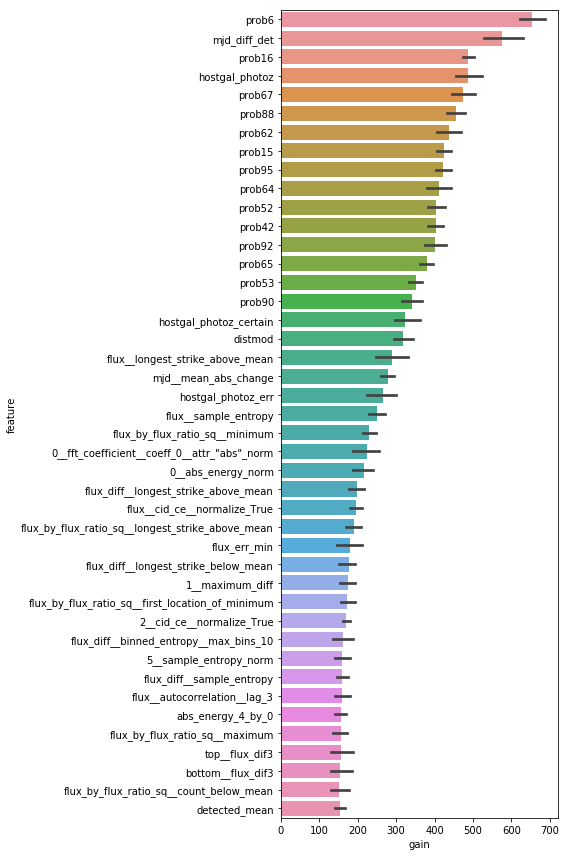

In [48]:
final_clfs, final_score, final_oof = lgbm_modeling_cross_validation(
    best_params,
    full_final,
    y_final,
    classes,
    class_weight,
    lgb_multi_weighted_logloss,
    multi_weighted_logloss,
    7,
    7
)

In [49]:
# 0.5061864253564666
final_score

0.5061864253564666

### 特徴量削減  
やらないほうがベターと判断。スキップ

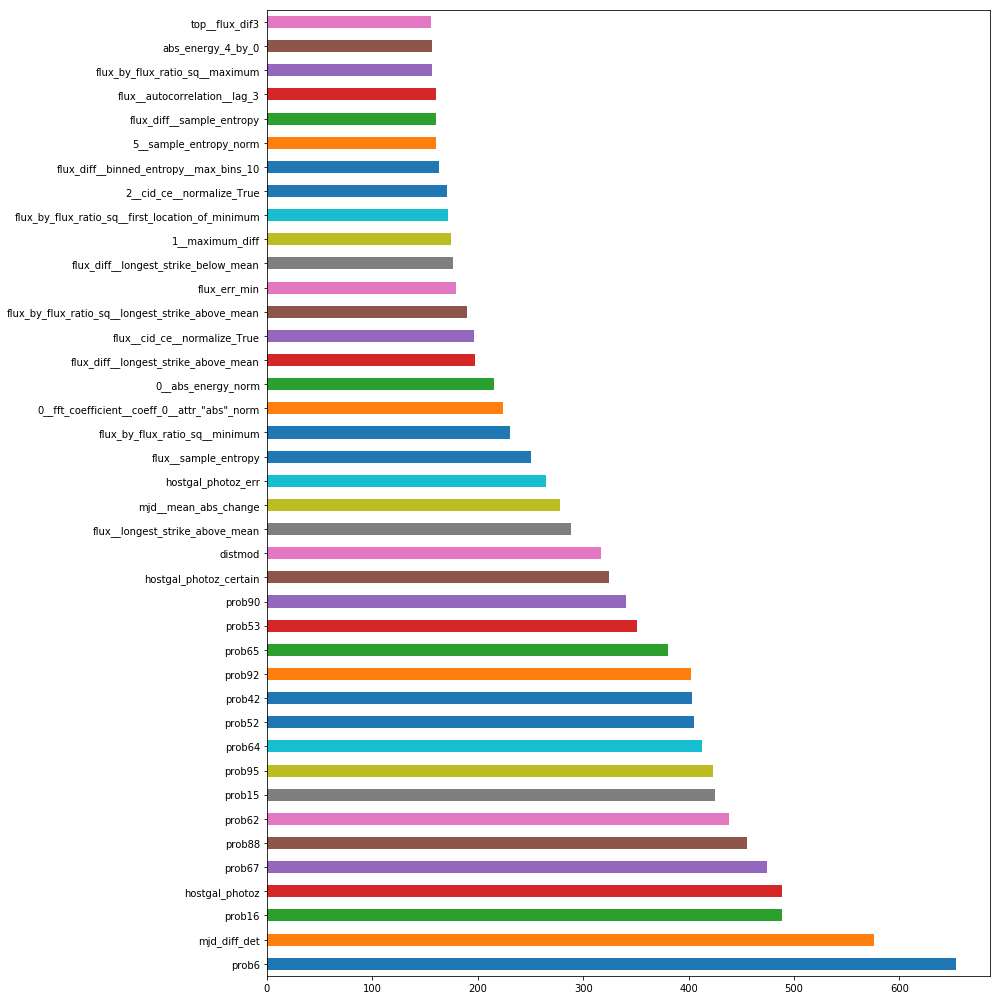

In [73]:
# importances = plot_importances(final_clfs, full_final.columns)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.205493	training's wloss: 0.507839	valid_1's multi_logloss: 1.26521	valid_1's wloss: 0.674611
[200]	training's multi_logloss: 0.0942671	training's wloss: 0.322964	valid_1's multi_logloss: 1.01948	valid_1's wloss: 0.537181
[300]	training's multi_logloss: 0.0691066	training's wloss: 0.257023	valid_1's multi_logloss: 0.913597	valid_1's wloss: 0.518607
Early stopping, best iteration is:
[310]	training's multi_logloss: 0.0674859	training's wloss: 0.252238	valid_1's multi_logloss: 0.906091	valid_1's wloss: 0.518092
no 1-fold loss: 0.5180924479908282
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.204087	training's wloss: 0.505124	valid_1's multi_logloss: 1.15537	valid_1's wloss: 0.664723
[200]	training's multi_logloss: 0.0937051	training's wloss: 0.323058	valid_1's multi_logloss: 0.926057	valid_1's wloss: 0.534418
[300]	training's multi_logloss: 0.069

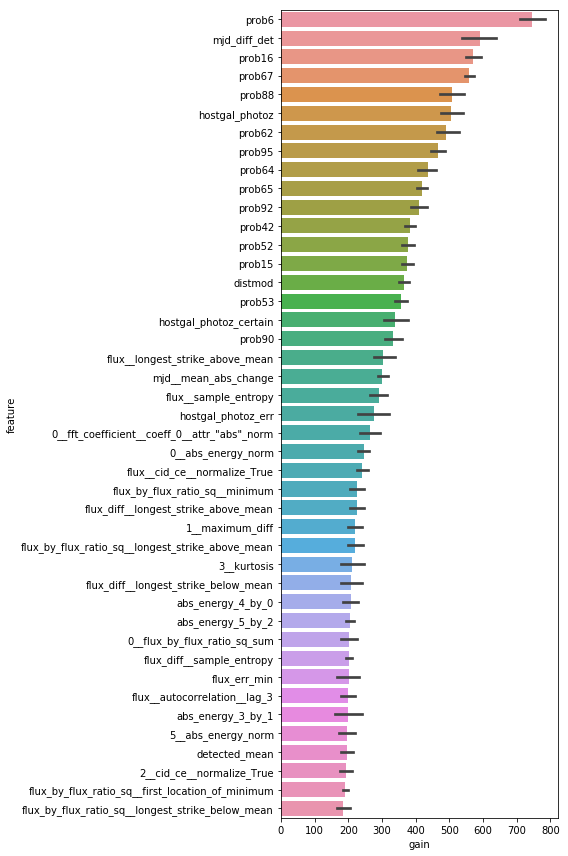

In [83]:
# n_drop = 50
# features = importances.iloc[:-n_drop].index.tolist()
# final_clfs, final_score, final_oof = lgbm_modeling_cross_validation(
#     best_params,
#     full_final[features],
#     y_final,
#     classes,
#     class_weight,
#     lgb_multi_weighted_logloss,
#     multi_weighted_logloss,
#     7,
#     7
# )

In [84]:
# 0  0.5061864253564666
# 10 0.5084482798802108
# 20 0.5066705358652451
# 30 0.5044637598505551
# 40 0.5023329682559106
# 50 0.5028626191171858
# final_score

0.5028626191171858

### テストデータへモデルを適用

In [67]:
import time
import gc
gc.enable()

def gen_unknown_simple(series):
    """
    from https://www.kaggle.com/c/PLAsTiCC-2018/discussion/72104#426782
    """
    return (0.5 + 0.5 * series.median() + 0.25 * series.mean() -
            0.5 * series.max()**3) / 2.

def predict_chunk(full_test, 
                 bin_clfs_, 
                 nova_clfs, 
                 nonnova_clfs, 
                 final_clfs):
    object_id = full_test['object_id'].values
    full_test = full_test.drop('object_id', axis=1)
    
    # 二値分類の実施
    print('binary processing...')
    bin_preds_ = None
    for clf in bin_clfs_:
        if bin_preds_ is None:
            bin_preds_ = clf.predict_proba(full_test) / len(bin_clfs_)
        else:
            bin_preds_ += clf.predict_proba(full_test) / len(bin_clfs_)
    bin_preds_ = np.argmax(bin_preds_, axis=1) # 二値分類の予測値
    
    # novaの予測
    print('nova processing...')
    nova_preds = None
    for clf in nova_clfs:
        if nova_preds is None:
            nova_preds = clf.predict_proba(full_test.loc[np.where(bin_preds_ == 1.0)[0], :]) / len(nova_clfs)
        else:
            nova_preds += clf.predict_proba(full_test.loc[np.where(bin_preds_ == 1.0)[0], :]) / len(nova_clfs)
    
    # nonnovaの予測
    print('non nova processing...')
    nonnova_preds = None
    for clf in nonnova_clfs:
        if nonnova_preds is None:
            nonnova_preds = clf.predict_proba(full_test.loc[np.where(bin_preds_ == 0.0)[0], :]) / len(nonnova_clfs)
        else:
            nonnova_preds += clf.predict_proba(full_test.loc[np.where(bin_preds_ == 0.0)[0], :]) / len(nonnova_clfs)
    
    # 予測特徴量の作成
    full_test['object_id'] = object_id
    prob_matrix = get_prob_matrix(
        nova_preds, 
        nonnova_preds, 
        full_test.loc[np.where(bin_preds_ == 1.0)[0], "object_id"].values, 
        full_test.loc[np.where(bin_preds_ == 0.0)[0], "object_id"].values)
    prob_matrix.sort_values(by="object_id", ascending=True, inplace=True)
    prob_matrix.reset_index(inplace=True, drop=True)
    
    full_test = pd.concat([full_test, prob_matrix], axis=1)
    full_test = full_test.drop('object_id', axis=1)
    
    # final予測の実行
    print('full processing...')
    preds_ = None
    for clf in final_clfs:
        if preds_ is None:
            preds_ = clf.predict_proba(full_test) / len(final_clfs)
        else:
            preds_ += clf.predict_proba(full_test) / len(final_clfs)
    
    # Create DataFrame from predictions
#     preds_df_ = pd.DataFrame(preds_, columns=['class_{}'.format(s) for s in final_clfs[0].classes_])
#     preds_99 = preds_df_.apply(lambda x: gen_unknown_simple(x), axis=1)
#     preds_df_['object_id'] = object_id
#     preds_df_['class_99'] = 0.18 * preds_99 / np.mean(preds_99)
    
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_,
                             columns=['class_{}'.format(s) for s in final_clfs[0].classes_])
    preds_df_['object_id'] = object_id
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99)
    
    return preds_df_

def process_test(bin_clfs, 
                 nova_clfs, 
                 nonnova_clfs, 
                 final_clfs, 
                 filename='predictions.csv',
                 chunks=5000000):
    start = time.time()
    
    remain_df = None
    for i_c, df in enumerate(pd.read_csv('./featured_test_5-0.csv', chunksize=chunks, iterator=True)):
        print('{:15d} start'.format(chunks * (i_c + 1)))
        # Check object_ids
        # I believe np.unique keeps the order of group_ids as they appear in the file
        unique_ids = np.unique(df['object_id'])

        new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()
        if remain_df is None:
            df = df.loc[df['object_id'].isin(unique_ids[:-1])]
        else:
            df = pd.concat(
                [remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]],
                axis=0)
        # Create remaining samples df
        remain_df = new_remain_df
        
        # 予測の実行
        df.reset_index(drop=True, inplace=True)
        preds_df = predict_chunk(df, bin_clfs, nova_clfs, nonnova_clfs, final_clfs)

        if i_c == 0:
            preds_df.to_csv(filename, header=True, mode='a', index=False)
        else:
            preds_df.to_csv(filename, header=False, mode='a', index=False)

        del preds_df
        gc.collect()
        print(
            '{:15d} done in {:5.1f} minutes'.format(
                chunks * (i_c + 1), (time.time() - start) / 60),
            flush=True)

    # Compute last object in remain_df
    remain_df.reset_index(drop=True, inplace=True)
    preds_df = predict_chunk(remain_df, bin_clfs, nova_clfs, nonnova_clfs, final_clfs)
    preds_df.to_csv(filename, header=False, mode='a', index=False)
    
    return

In [68]:
from datetime import datetime as dt
# テストデータの作成
filename = 'subm_{:.6f}_{}.csv'.format(final_score, dt.now().strftime('%Y-%m-%d-%H-%M'))
print('save to {}'.format(filename))

save to subm_0.506186_2018-12-17-10-35.csv


In [84]:
full_test = pd.read_csv('./featured_test_5-0.csv')

In [62]:
%%time
preds_df = predict_chunk(full_test, bin_clfs, nova_clfs, nonnova_clfs, final_clfs)

binary processing...
nova processing...
non nova processing...
full processing...
CPU times: user 3h 20min 29s, sys: 9min 42s, total: 3h 30min 12s
Wall time: 4min 53s


In [63]:
print(preds_df.shape)
preds_df_after = preds_df.groupby('object_id').mean()
print(preds_df_after.shape)

(3492891, 16)
(3492890, 15)


In [64]:
preds_df_after.to_csv('single_{}'.format(filename), index=True)

### 1つ1つ実行してバグがないか確認

In [86]:
# データの読み込み
full_test = pd.read_csv('./featured_test_5-0.csv')
object_id = full_test['object_id'].values
full_test = full_test.drop('object_id', axis=1)
bin_clfs_ = bin_clfs

In [87]:
%%time
# 二値分類の実施
print('binary processing...')
bin_preds_ = None
for clf in bin_clfs_:
    if bin_preds_ is None:
        bin_preds_ = clf.predict_proba(full_test) / len(bin_clfs_)
    else:
        bin_preds_ += clf.predict_proba(full_test) / len(bin_clfs_)
bin_preds_raw = bin_preds_.copy()
bin_preds_ = np.argmax(bin_preds_, axis=1) # 二値分類の予測値

binary processing...
CPU times: user 15min 41s, sys: 2min 56s, total: 18min 37s
Wall time: 45.1 s


In [91]:
print(len(np.where(bin_preds_ == 0)[0]))
print(len(np.where(bin_preds_ == 1)[0]))

606256
2886635


In [ ]:
# novaの予測
print('nova processing...')
nova_preds = None
for clf in nova_clfs:
    if nova_preds is None:
        nova_preds = clf.predict_proba(full_test.loc[np.where(bin_preds_ == 1.0)[0], :]) / len(nova_clfs)
    else:
        nova_preds += clf.predict_proba(full_test.loc[np.where(bin_preds_ == 1.0)[0], :]) / len(nova_clfs)

# nonnovaの予測
print('non nova processing...')
nonnova_preds = None
for clf in nonnova_clfs:
    if nonnova_preds is None:
        nonnova_preds = clf.predict_proba(full_test.loc[np.where(bin_preds_ == 0.0)[0], :]) / len(nonnova_clfs)
    else:
        nonnova_preds += clf.predict_proba(full_test.loc[np.where(bin_preds_ == 0.0)[0], :]) / len(nonnova_clfs)

# 予測特徴量の作成
full_test['object_id'] = object_id
prob_matrix = get_prob_matrix(
    nova_preds, 
    nonnova_preds, 
    full_test.loc[np.where(bin_preds_ == 1.0)[0], "object_id"].values, 
    full_test.loc[np.where(bin_preds_ == 0.0)[0], "object_id"].values)
prob_matrix.sort_values(by="object_id", ascending=True, inplace=True)
prob_matrix.reset_index(inplace=True, drop=True)

full_test = pd.concat([full_test, prob_matrix], axis=1)
full_test = full_test.drop('object_id', axis=1)

# final予測の実行
print('full processing...')
preds_ = None
for clf in final_clfs:
    if preds_ is None:
        preds_ = clf.predict_proba(full_test) / len(final_clfs)
    else:
        preds_ += clf.predict_proba(full_test) / len(final_clfs)

# Create DataFrame from predictions
#     preds_df_ = pd.DataFrame(preds_, columns=['class_{}'.format(s) for s in final_clfs[0].classes_])
#     preds_99 = preds_df_.apply(lambda x: gen_unknown_simple(x), axis=1)
#     preds_df_['object_id'] = object_id
#     preds_df_['class_99'] = 0.18 * preds_99 / np.mean(preds_99)

preds_99 = np.ones(preds_.shape[0])
for i in range(preds_.shape[1]):
    preds_99 *= (1 - preds_[:, i])

# Create DataFrame from predictions
preds_df_ = pd.DataFrame(preds_,
                         columns=['class_{}'.format(s) for s in final_clfs[0].classes_])
preds_df_['object_id'] = object_id
preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99)

In [65]:
preds_df_after

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000321,0.000775,0.000083,0.837557,0.061098,0.001078,0.086804,0.000436,0.000081,0.001635,0.000157,0.009464,0.000216,0.000295,0.073203
14,0.000286,0.005366,0.000099,0.159349,0.059222,0.000933,0.046814,0.000386,0.000143,0.006686,0.000475,0.719631,0.000349,0.000260,0.111037
17,0.000366,0.002077,0.000136,0.075402,0.348316,0.001171,0.010212,0.000768,0.000116,0.017747,0.000521,0.542499,0.000255,0.000414,0.142101
23,0.000394,0.001074,0.000123,0.063744,0.007719,0.001284,0.065424,0.000853,0.000161,0.622432,0.000240,0.235912,0.000256,0.000384,0.132951
34,0.000382,0.001263,0.000132,0.020190,0.679783,0.001285,0.007581,0.000527,0.000125,0.003281,0.000205,0.284645,0.000265,0.000335,0.117867
35,0.000415,0.000950,0.000117,0.025333,0.079840,0.001373,0.020578,0.000561,0.000209,0.424309,0.000229,0.445351,0.000268,0.000468,0.148897
43,0.000170,0.000577,0.000048,0.022749,0.003456,0.000543,0.033290,0.000353,0.000091,0.130934,0.000152,0.807359,0.000109,0.000169,0.083873
50,0.000283,0.002403,0.000111,0.022230,0.004328,0.000847,0.248260,0.000569,0.000147,0.298346,0.000208,0.421820,0.000168,0.000280,0.157546
60,0.000370,0.000696,0.000111,0.082209,0.010563,0.001231,0.208941,0.000500,0.000107,0.349748,0.000207,0.344649,0.000243,0.000426,0.162625


### 0.50のやつと0.52のやつの出力結果を比較

In [95]:
preds_df_52 = pd.read_csv('./single_subm_0.524940_2018-12-17-10-36.csv', index_col=0)

In [96]:
preds_df_52

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000391,0.000978,0.000090,0.827029,0.053182,0.001335,0.099686,0.000543,0.000088,0.001929,0.000188,0.013941,0.000264,0.000355,0.098977
14,0.000402,0.003578,0.000130,0.164694,0.039179,0.001362,0.054060,0.000570,0.000167,0.004631,0.000551,0.729831,0.000445,0.000400,0.136215
17,0.000507,0.002968,0.000191,0.090671,0.369656,0.001680,0.012627,0.000996,0.000141,0.020524,0.000625,0.498453,0.000371,0.000589,0.191983
23,0.000586,0.001783,0.000161,0.092983,0.014992,0.001952,0.040228,0.001161,0.000195,0.624881,0.000353,0.219768,0.000381,0.000577,0.166751
34,0.000383,0.001651,0.000128,0.019127,0.567137,0.001308,0.006625,0.000543,0.000121,0.002921,0.000206,0.399243,0.000264,0.000343,0.179583
35,0.000546,0.001517,0.000136,0.028300,0.135644,0.001869,0.021991,0.000772,0.000285,0.324223,0.000303,0.483388,0.000355,0.000671,0.194233
43,0.000451,0.001793,0.000110,0.050227,0.008857,0.001513,0.081496,0.000867,0.000182,0.274284,0.000344,0.579146,0.000290,0.000442,0.177151
50,0.000422,0.002098,0.000137,0.032330,0.007363,0.001265,0.194436,0.000755,0.000184,0.296693,0.000264,0.463376,0.000244,0.000431,0.197033
60,0.000487,0.000953,0.000122,0.077821,0.022014,0.001664,0.150383,0.000679,0.000128,0.269903,0.000268,0.474676,0.000315,0.000588,0.195425


In [97]:
class_labels = list(preds_df_after.columns)
label_list = []
for record in preds_df_after.values:
    label_list.append(class_labels[np.argmax(record)])

label_list_52 = []
for record in preds_df_52.values:
    label_list_52.append(class_labels[np.argmax(record)])

In [98]:
compare_df = pd.DataFrame({'50':label_list, '52':label_list_52}, index=preds_df_after.index)

In [100]:
len(compare_df[compare_df['50'] != compare_df['52']])/len(compare_df)

0.2150646026642694

### 以下、workspace

In [58]:
process_test(bin_clfs=bin_clfs, 
             nova_clfs=nova_clfs, 
             nonnova_clfs=nonnova_clfs, 
             final_clfs=final_clfs, 
             filename=filename,
             chunks=20000000)

       20000000 start
binary processing...
nova processing...
non nova processing...
full processing...
       20000000 done in   7.9 minutes


NameError: name 'bin_clfs_' is not defined

In [52]:
%%time
# テスト用

chunks = 10000000
reader = pd.read_csv('./featured_test_5-0.csv', chunksize=chunks, iterator=True)

remain_df = None

i_c = 0
df = reader.get_chunk()

unique_ids = np.unique(df['object_id'])

new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()
if remain_df is None:
    df = df.loc[df['object_id'].isin(unique_ids[:-1])]
else:
    df = pd.concat(
        [remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]],
        axis=0)
# Create remaining samples df
remain_df = new_remain_df

df.reset_index(drop=True, inplace=True)

CPU times: user 2min 19s, sys: 13.8 s, total: 2min 33s
Wall time: 1min 59s


In [53]:
preds_df = predict_chunk(df, bin_clfs, nova_clfs, nonnova_clfs, final_clfs)
preds_df

binary processing...
nova processing...
non nova processing...
full processing...


,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,object_id,class_99
0,0.000321,0.000775,0.000083,0.837557,0.061098,0.001078,0.086804,0.000436,0.000081,0.001635,0.000157,0.009464,0.000216,0.000295,13,0.073218
1,0.000286,0.005366,0.000099,0.159349,0.059222,0.000933,0.046814,0.000386,0.000143,0.006686,0.000475,0.719631,0.000349,0.000260,14,0.111059
2,0.000366,0.002077,0.000136,0.075402,0.348316,0.001171,0.010212,0.000768,0.000116,0.017747,0.000521,0.542499,0.000255,0.000414,17,0.142129
3,0.000394,0.001074,0.000123,0.063744,0.007719,0.001284,0.065424,0.000853,0.000161,0.622432,0.000240,0.235912,0.000256,0.000384,23,0.132977
4,0.000382,0.001263,0.000132,0.020190,0.679783,0.001285,0.007581,0.000527,0.000125,0.003281,0.000205,0.284645,0.000265,0.000335,34,0.117891
5,0.000415,0.000950,0.000117,0.025333,0.079840,0.001373,0.020578,0.000561,0.000209,0.424309,0.000229,0.445351,0.000268,0.000468,35,0.148926
6,0.000170,0.000577,0.000048,0.022749,0.003456,0.000543,0.033290,0.000353,0.000091,0.130934,0.000152,0.807359,0.000109,0.000169,43,0.083889
7,0.000283,0.002403,0.000111,0.022230,0.004328,0.000847,0.248260,0.000569,0.000147,0.298346,0.000208,0.421820,0.000168,0.000280,50,0.157577
8,0.000370,0.000696,0.000111,0.082209,0.010563,0.001231,0.208941,0.000500,0.000107,0.349748,0.000207,0.344649,0.000243,0.000426,60,0.162657
9,0.000647,0.001579,0.000174,0.098441,0.051526,0.002154,0.276655,0.000903,0.000214,0.473872,0.000380,0.092274,0.000426,0.000755,69,0.156436


In [168]:
%%time
full_test = df.copy()
bin_clfs_ = bin_clfs

object_id = full_test['object_id'].values
full_test = full_test.drop('object_id', axis=1)

# 二値分類の実施
print('binary processing...')
bin_preds_ = None
for clf in bin_clfs_:
    if bin_preds_ is None:
        bin_preds_ = clf.predict_proba(full_test) / len(bin_clfs_)
    else:
        bin_preds_ += clf.predict_proba(full_test) / len(bin_clfs_)
bin_preds_ = np.argmax(bin_preds_, axis=1) # 二値分類の予測値

# novaの予測
print('nova processing...')
nova_preds = None
for clf in nova_clfs:
    if nova_preds is None:
        nova_preds = clf.predict_proba(full_test.loc[np.where(bin_preds_ == 1.0)[0], :]) / len(nova_clfs)
    else:
        nova_preds += clf.predict_proba(full_test.loc[np.where(bin_preds_ == 1.0)[0], :]) / len(nova_clfs)

# nonnovaの予測
print('non nova processing...')
nonnova_preds = None
for clf in nonnova_clfs:
    if nonnova_preds is None:
        nonnova_preds = clf.predict_proba(full_test.loc[np.where(bin_preds_ == 0.0)[0], :]) / len(nonnova_clfs)
    else:
        nonnova_preds += clf.predict_proba(full_test.loc[np.where(bin_preds_ == 0.0)[0], :]) / len(nonnova_clfs)

binary processing...
nova processing...
non nova processing...
CPU times: user 1h 28min 42s, sys: 5min 51s, total: 1h 34min 33s
Wall time: 2min 32s


In [169]:
# 予測特徴量の作成
full_test['object_id'] = object_id
prob_matrix = get_prob_matrix(
    nova_preds, 
    nonnova_preds, 
    full_test.loc[np.where(bin_preds_ == 1.0)[0], "object_id"], 
    full_test.loc[np.where(bin_preds_ == 0.0)[0], "object_id"])
prob_matrix.sort_values(by="object_id", ascending=True, inplace=True)
prob_matrix.reset_index(inplace=True, drop=True)

full_test = pd.concat([full_test, prob_matrix], axis=1)
full_test = full_test.drop('object_id', axis=1)

In [170]:
%%time
# final予測の実行
print('full processing...')
preds_ = None
for clf in final_clfs:
    if preds_ is None:
        preds_ = clf.predict_proba(full_test) / len(final_clfs)
    else:
        preds_ += clf.predict_proba(full_test) / len(final_clfs)
print('full done...')

full processing...
full done...
CPU times: user 1h 50min 28s, sys: 3min 21s, total: 1h 53min 50s
Wall time: 2min 6s


In [171]:
%%time
preds_df_ = pd.DataFrame(preds_, columns=['class_{}'.format(s) for s in final_clfs[0].classes_])

preds_99 = np.ones(preds_.shape[0])
for i in range(preds_.shape[1]):
    preds_99 *= (1 - preds_[:, i])

# Create DataFrame from predictions
preds_df_ = pd.DataFrame(preds_,
                         columns=['class_{}'.format(s) for s in final_clfs[0].classes_])
preds_df_['object_id'] = object_id
preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99)

CPU times: user 21.7 s, sys: 0 ns, total: 21.7 s
Wall time: 651 ms


In [61]:
%%time
preds_99 = preds_df_.apply(lambda x: gen_unknown_simple(x), axis=1)
preds_df_['object_id'] = object_id
preds_df_['class_99'] = 0.18 * preds_99 / np.mean(preds_99)

ValueError: Length of values does not match length of index

In [114]:
# 荒居くんの元々のやつ
def predict_test(full_test, 
                 bin_clfs_, 
                 nova_clfs, 
                 nonnova_clfs, 
                 final_clfs, 
                 bin_features, 
                 nova_features,
                 nonnova_features,
                 final_features):
    bin_preds_ = None
    for clf in bin_clfs_:
        if bin_preds_ is None:
            bin_preds_ = clf.predict_proba(full_test[bin_features]) / len(bin_clfs_)
        else:
            bin_preds_ += clf.predict_proba(full_test[bin_features]) / len(bin_clfs_)
    bin_preds_ = np.argmax(bin_preds_, axis=1)
    
    nova_preds = None
    for clf in nova_clfs:
        if nova_preds is None:
            nova_preds = clf.predict_proba(full_test.loc[np.where(bin_preds_ == 1.0)[0], nova_features]) / len(nova_clfs)
        else:
            nova_preds += clf.predict_proba(full_test.loc[np.where(bin_preds_ == 1.0)[0], nova_features]) / len(nova_clfs)
            
    nonnova_preds = None
    for clf in nonnova_clfs:
        if nonnova_preds is None:
            nonnova_preds = clf.predict_proba(full_test.loc[np.where(bin_preds_ == 0.0)[0], nonnova_features]) / len(nonnova_clfs)
        else:
            nonnova_preds += clf.predict_proba(full_test.loc[np.where(bin_preds_ == 0.0)[0], nonnova_features]) / len(nonnova_clfs)
    prob_matrix = get_prob_matrix(
        nova_preds, 
        nonnova_preds, 
        full_test.loc[np.where(bin_preds_ == 1.0)[0], "object_id"], 
        full_test.loc[np.where(bin_preds_ == 0.0)[0], "object_id"])
    prob_matrix.sort_values(by="object_id", ascending=True, inplace=True)
    prob_matrix.reset_index(inplace=True)
    full_test = pd.concat([full_test, prob_matrix], axis=1)[final_features]
    
    preds_ = None
    for clf in final_clfs:
        if preds_ is None:
            preds = clf.predict_proba(full_final) / len(final_clfs)
        else:
            preds += clf.predict_proba(full_final) / len(final_clfs)

    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    return preds_df_

In [118]:
for c in full_test.columns:
    if "top__" in c or "bottom__" in c:
        print(c)

top__abs_energy_norm
bottom__abs_energy_norm
top__flux_diff
bottom__flux_diff
top__flux_dif3
bottom__flux_dif3


In [ ]:
preds_df = predict_test(
    full_test=full_test,
    bin_clfs_=bin_clfs,
    nova_clfs=nova_clfs,
    nonnova_clfs=nonnova_clfs,
    final_clfs=final_clfs,
    bin_features=full_bin.columns,
    nova_features=full_novae.columns,
    nonnova_features=full_nonnova.columns,
    final_features=full_final.columns
)

preds_df.to_csv("predictions_staged.csv", index=False)
del preds_df, full_test
print(f'done in {(time.time() - start) / 60} minutes', flush=True)

In [ ]:
import gc
gc.enable()
import time
start = time.time()

full_test = pd.read_csv("full_final.csv")


In [ ]:
!zip predictions_staged.csv.zip predictions_staged.csv
!kaggle competitions submit -c PLAsTiCC-2018 -f predictions_staged.csv.zip -m "two staged model test"